In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from nltk.corpus import stopwords
# Need to uncomment the following line in order to download nltk stopwords:
# nltk.download('stopwords')
import re
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from collections import defaultdict
from collections import Counter, ChainMap

from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensim_models

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [3]:
pd.options.mode.chained_assignment = None

with open('data/dk_asylum_data.json', encoding='utf-8') as inputfile:
    df_full = pd.read_json(inputfile)

# Convert json to csv:
df_full.to_csv('data/dk_asylum_data.csv', encoding='utf-8', index=False)

df_full.shape


(9324, 5)

# Data preprocessing:

## Keep cases of Unknown Homeland (Ukendt hjemland):

In [4]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

df.head()


,text
201,Nævnet stadfæstede i november 2021 Udl...
428,Nævnet stadfæstede i juni 2021 Udlændi...
464,Nævnet stadfæstede i juni 2021 Udlændi...
901,Nævnet stadfæstede i december 2020 Udl...
1291,Nævnet hjemviste i juni 2020 Udlænding...


## Lower casing:

In [5]:
df["text_lower"] = df["text"].str.lower()
df.head()


,text,text_lower
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede i november 2021 udl...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede i december 2020 udl...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste i juni 2020 udlænding...


## Punctuation removal:

In [6]:
PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede i november 2021 udl...,nævnet stadfæstede i november 2021 udl...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede i juni 2021 udlændi...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede i juni 2021 udlændi...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede i december 2020 udl...,nævnet stadfæstede i december 2020 udl...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste i juni 2020 udlænding...,nævnet hjemviste i juni 2020 udlænding...


## Stopwords removal:

In [7]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('danish')))

STOPWORDS_DANISH = set(stopwords_lower)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if not word in STOPWORDS_DANISH])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede i november 2021 udl...,nævnet stadfæstede i november 2021 udl...,nævnet stadfæstede november 2021 udlændingesty...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede i juni 2021 udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede i december 2020 udl...,nævnet stadfæstede i december 2020 udl...,nævnet stadfæstede december 2020 udlændingesty...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste i juni 2020 udlænding...,nævnet hjemviste i juni 2020 udlænding...,nævnet hjemviste juni 2020 udlændingestyrelsen...


## Numbers removal:

In [8]:
# Drop the columns which are no longer needed:
df.drop(["text_lower", 'text_wo_punct'], axis=1, inplace=True)


def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_wo_stop"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_stop,text_wo_numbers
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede november 2021 udlændingesty...,nævnet stadfæstede november udlændingestyrels...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...,nævnet stadfæstede juni udlændingestyrelsens ...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...,nævnet stadfæstede juni udlændingestyrelsens ...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede december 2020 udlændingesty...,nævnet stadfæstede december udlændingestyrels...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste juni 2020 udlændingestyrelsen...,nævnet hjemviste juni udlændingestyrelsens af...


## Single character words removal:

In [9]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_stop,text_wo_numbers,text_wo_single_letters
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede november 2021 udlændingesty...,nævnet stadfæstede november udlændingestyrels...,nævnet stadfæstede november udlændingestyrelse...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...,nævnet stadfæstede juni udlændingestyrelsens ...,nævnet stadfæstede juni udlændingestyrelsens a...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni 2021 udlændingestyrels...,nævnet stadfæstede juni udlændingestyrelsens ...,nævnet stadfæstede juni udlændingestyrelsens a...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede december 2020 udlændingesty...,nævnet stadfæstede december udlændingestyrels...,nævnet stadfæstede december udlændingestyrelse...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste juni 2020 udlændingestyrelsen...,nævnet hjemviste juni udlændingestyrelsens af...,nævnet hjemviste juni udlændingestyrelsens afg...


## Tokenize text:

In [10]:
# Drop the columns which are no longer needed
df.drop(["text_wo_stop", 'text_wo_numbers'], axis=1, inplace=True)

nlp = spacy.load("da_core_news_sm")


def tokenize_text(text):
    doc = nlp.tokenizer(text)
    return ' '.join([token.text for token in doc])


df["text_tokenized"] = df["text_wo_single_letters"].apply(
    lambda text: tokenize_text(text))

df.head()


,text,text_wo_single_letters,text_tokenized
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede november udlændingestyrelse...,nævnet stadfæstede november udlændingestyrelse...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni udlændingestyrelsens a...,nævnet stadfæstede juni udlændingestyrelsens a...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni udlændingestyrelsens a...,nævnet stadfæstede juni udlændingestyrelsens a...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede december udlændingestyrelse...,nævnet stadfæstede december udlændingestyrelse...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste juni udlændingestyrelsens afg...,nævnet hjemviste juni udlændingestyrelsens afg...


## Lemmatization:

In [11]:
def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return ' '.join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_tokenized"].apply(
    lambda text: lemmatize_words(text))
df.head()


,text,text_wo_single_letters,text_tokenized,text_lemmatized
201,Nævnet stadfæstede i november 2021 Udl...,nævnet stadfæstede november udlændingestyrelse...,nævnet stadfæstede november udlændingestyrelse...,nævn stadfæste november udlændingestyrelse afg...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni udlændingestyrelsens a...,nævnet stadfæstede juni udlændingestyrelsens a...,nævn stadfæste juni udlændingestyrelse afgørel...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævnet stadfæstede juni udlændingestyrelsens a...,nævnet stadfæstede juni udlændingestyrelsens a...,nævn stadfæste juni udlændingestyrelse afgørel...
901,Nævnet stadfæstede i december 2020 Udl...,nævnet stadfæstede december udlændingestyrelse...,nævnet stadfæstede december udlændingestyrelse...,nævn stadfæste december udlændingestyrelse afg...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævnet hjemviste juni udlændingestyrelsens afg...,nævnet hjemviste juni udlændingestyrelsens afg...,nævn hjemviste juni udlændingestyrelse afgørel...


## No-sense words removal:

In [12]:
df.drop(["text_wo_single_letters", 'text_tokenized'], axis=1, inplace=True)

# Using spacy’s pos_ attribute, we can check if a particular token
# is junk (i.e do not mean anything) through token.pos_ == 'X' and remove them.


def remove_junk(text):
    # Creating a spacy object
    doc = nlp(text)
    # Checking if POS tag is X and printing them
    for token in doc:
        if token.pos_ == 'X':
            print(token.text)
    # Removing the tokens whose POS tag is junk.
    clean_doc = [token.text for token in doc if not token.pos_ == 'X']

    return ' '.join(clean_doc)


df['no_junk'] = df["text_lemmatized"].apply(lambda text: remove_junk(text))

df.head()


oplyse
måned
hjælpe
holland
måned
tale
tag
frigive
følge
påberåbe
sprogtests
in
birth
påberåbe
tilknytte
bevisførelse
ortodoks
oplyse
gengive
statsborgerskab
fremlægge
udstede
måned
bopæl
afgive
række
hense
hense
mobiltelefon
tag
virke
hense
as
most
frieri
måned
bopæl
afgive
række
hense
hense
mobiltelefon
tag
virke
hense
oplyse
oplyse
hense
bo
begrænse
rohingya
familie
foto
udstede
specimen
foto
genindkalde
passe
afgive
afgive
sammenholde
tag
hjemlandhjemyars
as
es
læg
føde
måned
es
læg
oplyse
måned
es
læg
anholde
måned
es
es
læg
angribe
tag
oplyse
føde
fremgå
udlændingelov
følge
gø
oplyse
bo
whatsapp
gø
afgive
tag
tie
måned
halv
afgøre
udstede
læg
bopæl
trække
oplyse
kl
følge
udlændingelov
udlænding
møde
tag
påberåbe
følge
udlændingelov
møde
tag
tag
hense
læg
påberåbe
hense
følge
overdrage
tag
hjemmeside
politirapport
tidlig
oplyse
politirapport
land
politirapport
medlem
oplyse
isil
kl
kl
nævnsmøde
oplyse
følge
oplyse
slave
detaljeringsgrad
asylkort
nævnsmøde
udlændingelov
afslag
afgi

,text,text_lemmatized,no_junk
201,Nævnet stadfæstede i november 2021 Udl...,nævn stadfæste november udlændingestyrelse afg...,nævn stadfæste november udlændingestyrelse afg...
428,Nævnet stadfæstede i juni 2021 Udlændi...,nævn stadfæste juni udlændingestyrelse afgørel...,nævn stadfæste juni udlændingestyrelse afgørel...
464,Nævnet stadfæstede i juni 2021 Udlændi...,nævn stadfæste juni udlændingestyrelse afgørel...,nævn stadfæste juni udlændingestyrelse afgørel...
901,Nævnet stadfæstede i december 2020 Udl...,nævn stadfæste december udlændingestyrelse afg...,nævn stadfæste december udlændingestyrelse afg...
1291,Nævnet hjemviste i juni 2020 Udlænding...,nævn hjemviste juni udlændingestyrelse afgørel...,nævn hjemviste juni udlændingestyrelse afgørel...


# Analysis:

## N-gram analysis:

**N-grams** are neighboring sequences of items (words, letters, symbols) in a document. 

Most of the times a probability is assigned to the occurrence of a N-gram (or a word occurring next in a sequence of words). This can help decide which N-grams can be chunked together to form single entities or make predictions for next words (other possible use cases include spelling corrections).  

[Here](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf), are some slides from Stanford which provide an introduction to N-gram models and the math that goes with it. 

In [13]:
def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_DANISH)]
    # print("Sentence after removing stopwords:", words)
    temp = zip(*[words[i:] for i in range(0, ngram)])
    ans = [' '.join(ngram) for ngram in temp]
    return ans


values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['no_junk']:
    for word in generate_N_grams(text, 2):
        values[word] += 1


In [14]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


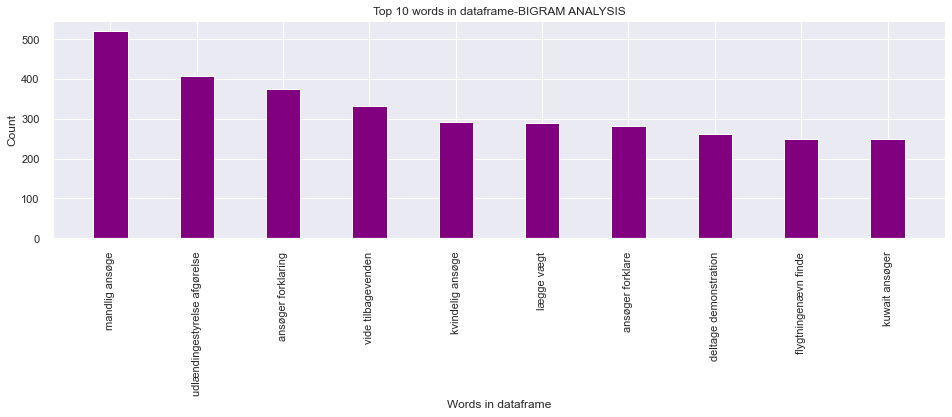

In [15]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


## TF-IDF

**Term Frequency (TF):**

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

A value close to 1 indicates this term is very important to the document — and primarily composed of it. A low value could mean this term is not very important.

**Inverse Data Frequency (IDF):**

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

A value close to 0 indicates the term is very common — and not very helpful in differentiating this document from another. A higher value indicates the term is not very common and could be crucial to understanding the theme of this document.

The **TF-IDF** is the multiplication of TF by IDF.

A value close to 0 indicates the term is not important either in the corpus or the document or both. A larger value indicates the term is unique for the document or the corpus or both. This value works best in relation to other terms in the same document, and other documents.

In [16]:
# Get the column of interest:
docs = df['no_junk'].tolist()

# Create a vocabulary of words, ignore words that appear in 85% of documents,
# Eliminate stop words if any:
cv = CountVectorizer(stop_words=STOPWORDS_DANISH)
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(192, 3399)

In [17]:
word_count_vector = cv.fit_transform(docs)

# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['nævn',
 'stadfæste',
 'november',
 'udlændingestyrelse',
 'afgørelse',
 'vedrøre',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland']

In [18]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)

# Look at the IDF values:
tfidf_transformer.idf_


array([5.1640779 , 5.56954301, 5.1640779 , ..., 4.65325228, 5.56954301,
       1.08654046])

In [19]:
# Sorts the values in the vector while preserving the column index
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)


def extract_top_n_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""

    # Use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]

        # Keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(fname)

    # Create a tuples of feature,score
    # results = zip(feature_vals,score_vals)
    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]] = score_vals[idx]

    return results


In [20]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 192 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())

    # extract only the top n; n here is 10
    keywords = extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF


,doc,keywords
0,nævn stadfæste november udlændingestyrelse afg...,"{'myanmar': 0.393, 'ansøger': 0.343, 'rohingya..."
1,nævn stadfæste juni udlændingestyrelse afgørel...,"{'algeriet': 0.492, 'ansøger': 0.429, 'gidsel'..."
2,nævn stadfæste juni udlændingestyrelse afgørel...,"{'ansøger': 0.408, 'sudan': 0.297, 'sydsudan':..."
3,nævn stadfæste december udlændingestyrelse afg...,"{'somalia': 0.439, 'alshabaab': 0.423, 'kenya'..."
4,nævn hjemviste juni udlændingestyrelse afgørel...,"{'eritreisk': 0.373, 'eritrea': 0.362, 'etiopi..."
...,...,...
187,nævn stadfæste februar udlændingestyrelse afgø...,"{'fader': 0.388, 'liyu': 0.358, 'police': 0.30..."
188,nævn stadfæste juli udlændingestyrelse afgørel...,"{'onlf': 0.37, 'ansøger': 0.36, 'police': 0.30..."
189,nævn hjemviste juli udlændingestyrelse afgørel...,"{'bør': 0.478, 'foretage': 0.174, 'etiopien': ..."
190,nævn stadfæste maj udlændingestyrelse afgørels...,"{'soldat': 0.526, 'ansøger': 0.271, 'hytte': 0..."


In [21]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

print(most_common)


[('klager', 0.851), ('officer', 0.604), ('taliban', 0.554), ('soldat', 0.526), ('algeriet', 0.492), ('police', 0.491), ('liyu', 0.491), ('libyen', 0.49), ('ægtefælle', 0.467), ('tjetjenien', 0.461), ('georgien', 0.461), ('sierra', 0.459), ('leone', 0.459), ('holland', 0.456), ('avis', 0.454), ('somalia', 0.439), ('libysk', 0.434), ('hær', 0.434), ('ghanesisk', 0.433), ('alshabaab', 0.423)]


## Topic Modelling:

Using Latent Dirichlet Allocation (LDA)

For a given corpus, a topic model estimates a topic distribution for each of its documents (i.e., a a distribution of weights over a set of topics), where a topic is itself a distribution of weights over the vocabulary of the corpus. The most weighted words of each topic are syntactically and/or semantically related, given that collection of documents. This means that two distinct topics share the exact same vocabulary, but have different weight distributions.

In [22]:
docs = [d.split() for d in docs]

# Create dictionary
dictionary = corpora.Dictionary(docs)

# Create document term matrix
bow = [dictionary.doc2bow(text) for text in docs]


Compute the coherence score is essentially a measure of how similar the words assigned to each topic are in terms of semantic value. The higher the score, the better.

Compute the coherence score for LDA models with 2 to 10 topics and see which number of topics leads to the highest coherence score.

Topic coherence in essence measures the human interpretability of a topic model. Traditionally perplexity has been used to evaluate topic models however this does not correlate with human annotations at times. Topic coherence is another way to evaluate topic models with a much higher guarantee on human interpretability. Thus this can be used to compare different topic models among many other use-cases.

In [23]:
best_num = float('NaN')
best_score = 0

# Compute the coherence scores for each number of topics
for i in range(2, 11):

    # Create lda model with i topics
    lda = LdaModel(corpus=bow, num_topics=i,
                   id2word=dictionary, random_state=42)

    # Obtain the coherence score
    coherence_model = CoherenceModel(
        model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score = np.round(coherence_model.get_coherence(), 2)
    if coherence_score > best_score:
        best_num = i
        best_score = coherence_score

print(f'The coherence score ({best_score}) is highest with {best_num} topics.')


The coherence score is highest (0.32) with 2 topics.


In [24]:
# Build the lda model
lda_model = LdaModel(corpus=bow,
                     id2word=dictionary,
                     num_topics=best_num,
                     random_state=42)


# Show the words most strongly associated with each topic
for topic in lda_model.print_topics():
    print(topic)


(0, '0.063*"ansøger" + 0.021*"flygtningenævn" + 0.020*"kuwait" + 0.013*"forklare" + 0.010*"udlændingestyrelse" + 0.010*"mandlig" + 0.010*"vide" + 0.010*"myndighed" + 0.009*"demonstration" + 0.009*"ansøge"')
(1, '0.061*"ansøger" + 0.018*"flygtningenævn" + 0.018*"forklare" + 0.017*"kuwait" + 0.012*"ansøge" + 0.011*"oplyse" + 0.011*"myndighed" + 0.011*"vide" + 0.010*"mandlig" + 0.010*"forklaring"')


In [28]:
# Visualize LDA model results
pyLDAvis.enable_notebook()

gensim_models.prepare(lda_model, dictionary=dictionary, corpus=bow)


/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jnap/opt/anaconda3/lib/python3.9/site-p

PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.004121  0.0       1        1  60.81769
0     -0.004121  0.0       2        1  39.18231, topic_info=                   Term         Freq        Total Category  logprob  loglift
6               ansøger  4671.000000  4671.000000  Default  30.0000  30.0000
48       flygtningenævn  1477.000000  1477.000000  Default  29.0000  29.0000
741              kuwait  1380.000000  1380.000000  Default  28.0000  28.0000
192  udlændingestyrelse   634.000000   634.000000  Default  27.0000  27.0000
168           stadfæste   363.000000   363.000000  Default  26.0000  26.0000
..                  ...          ...          ...      ...      ...      ...
57           forklaring   216.163394   667.559385   Topic2  -4.9202  -0.1906
285             udrejse   195.929631   610.642816   Topic2  -5.0185  -0.1998
77                grund   138.696710   348.797685   Topic2  -5.3640   0.0147
170                 stk   140.179708   365.039074   Topic2  -5.3534  -0.0201
83              henvise   144.973910   407.393805   Topic2  -5.3197  -0.0963

[192 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1907      1  0.677661  afghanistan
1907      2  0.169415  afghanistan
2         1  0.584200    afgørelse
2         2  0.414088    afgørelse
1846      1  0.367798      alfatah
...     ...       ...          ...
205       2  0.344450    vurdering
206       1  0.667295         vægt
206       2  0.330913         vægt
210       1  0.502556           år
210       2  0.497531           år

[278 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

Each bubble in the plot represents a topic. The size of the bubble represents the proportion of cases that contain the topic, with a larger bubble corresponding to a higher proportion. 

The distance between the bubbles represents the similarity between the topics; the shorter the distance, the more similar the topics.

The bars in the bar chart represent the term frequency for each of the words. The blue bars show the overall term frequency in the collection of documents, whereas the red bars show the term frequency for the selected topic.